In [ ]:
# run this notebook with the pathogen_probes-postseq_analyses environment/kernel

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ete3 import NCBITaxa
from tqdm.notebook import tqdm
from Bio import SeqIO
import re
import gzip

In [3]:
proj_dir="/master/nplatt/pathogen_probes/"
os.chdir(proj_dir)

## generate and update an ncbi taxonomy

In [3]:
ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

Updating taxdump.tar.gz from NCBI FTP site (via HTTP)...
Done. Parsing...


Loading node names...
2384729 names loaded.
260027 synonyms loaded.
Loading nodes...
2384729 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /master/nplatt/.etetoolkit/taxa.sqlite ...
 2384000 generating entries...  generating entries... generating entries... 
Uploading to /master/nplatt/.etetoolkit/taxa.sqlite


Inserting synonyms:      20000 

Inserting synonyms:      260000 

Inserting taxids:       10000  

Inserting taxids:       2380000 

## Get Sample Info

We are working with two different sequencing runs
 - 20201006_104744 - dual enrichment with 0.1% and 1e-3% pathogens at 0 (no enrichment), 63C + 63C, and 63C + 65C
 - 19047-21 - pooling

In [4]:
sample_info_df=pd.read_csv("{}/data/seq_data/sample_info.csv".format(proj_dir), sep=",")

In [5]:
sample_info_df

,sample_id,exp_num,exp_title,h1_temp,h2_temp,1x_enrich,2x_enrich,n_in_pool,pcr_cycles,notes,r1_fq,r2_fq
0,B5_n01_exp4,4,pooling strategy,63.0,65.0,False,True,1,15,a single sample pool that was enriched with tw...,B5_n01_exp4_R1.fastq.gz,B5_n01_exp4_R2.fastq.gz
1,B1_n04_exp4,4,pooling strategy,63.0,65.0,False,True,4,15,1 sample in a pool of 4 that was enriched with...,B1_n04_exp4_R1.fastq.gz,B1_n04_exp4_R2.fastq.gz
2,B2_n04_exp4,4,pooling strategy,63.0,65.0,False,True,4,15,1 sample in a pool of 4 that was enriched with...,B2_n04_exp4_R1.fastq.gz,B2_n04_exp4_R2.fastq.gz
3,B3_n04_exp4,4,pooling strategy,63.0,65.0,False,True,4,15,1 sample in a pool of 4 that was enriched with...,B3_n04_exp4_R1.fastq.gz,B3_n04_exp4_R2.fastq.gz
4,B4_n04_exp4,4,pooling strategy,63.0,65.0,False,True,4,15,1 sample in a pool of 4 that was enriched with...,B4_n04_exp4_R1.fastq.gz,B4_n04_exp4_R2.fastq.gz
5,B6_n16_exp4,4,pooling strategy,63.0,65.0,False,True,16,15,1 sample in a pool of 16 that was enriched wit...,B6_n16_exp4_R1.fastq.gz,B6_n16_exp4_R2.fastq.gz
6,B7_n16_exp4,4,pooling strategy,63.0,65.0,False,True,16,15,1 sample in a pool of 16 that was enriched wit...,B7_n16_exp4_R1.fastq.gz,B7_n16_exp4_R2.fastq.gz
7,B8_n16_exp4,4,pooling strategy,63.0,65.0,False,True,16,15,1 sample in a pool of 16 that was enriched wit...,B8_n16_exp4_R1.fastq.gz,B8_n16_exp4_R2.fastq.gz
8,B9_n16_exp4,4,pooling strategy,63.0,65.0,False,True,16,15,1 sample in a pool of 16 that was enriched wit...,B9_n16_exp4_R1.fastq.gz,B9_n16_exp4_R2.fastq.gz
9,B10_n16_exp4,4,pooling strategy,63.0,65.0,False,True,16,15,1 sample in a pool of 16 that was enriched wit...,B10_n16_exp4_R1.fastq.gz,B10_n16_exp4_R2.fastq.gz


In [ ]:
#download the genomes
# GCF_000237925.1 sch_man
# GCA_003958945.1 sch_bov
# GCF_000195955.2 myc_tub
# GCA_005156105.1 myc_bov
# GCF_000002765.5 pla_fal
# GCF_000002415.2 pla_viv 
# GCF_000001635.27 mus_mus
# GCF_000001405.39 hom_sap

In [ ]:
os.mkdir("results/genomes")

In [ ]:
%%bash

datasets download genome \
    --exclude-gff3 \
    --exclude-protein \
    --exclude-rna \
    --exclude-genomic-cds \
    --filename results/genomes/ncbi_datasets_download.zip \
    accession \
    GCF_000237925.1 \
    GCA_003958945.1 \
    GCF_000195955.2 \
    GCA_005156105.1 \
    GCF_000002765.5 \
    GCF_000002415.2 \
    GCF_000001635.27 \
    GCF_000001405.39

In [16]:
%%bash
unzip results/genomes/ncbi_datasets_download.zip -d results/genomes/

Archive:  results/genomes/ncbi_datasets_download.zip
  inflating: results/genomes/README.md  
  inflating: results/genomes/ncbi_dataset/data/assembly_data_report.jsonl  
  inflating: results/genomes/ncbi_dataset/data/GCA_003958945.1/GCA_003958945.1_ASM395894v1_genomic.fna  
  inflating: results/genomes/ncbi_dataset/data/GCA_005156105.1/GCA_005156105.1_ASM515610v1_genomic.fna  
  inflating: results/genomes/ncbi_dataset/data/GCF_000001405.39/chr1.fna  
  inflating: results/genomes/ncbi_dataset/data/GCF_000001405.39/chr1.unlocalized.scaf.fna  
  inflating: results/genomes/ncbi_dataset/data/GCF_000001405.39/chr2.fna  
  inflating: results/genomes/ncbi_dataset/data/GCF_000001405.39/chr2.unlocalized.scaf.fna  
  inflating: results/genomes/ncbi_dataset/data/GCF_000001405.39/chr3.fna  
  inflating: results/genomes/ncbi_dataset/data/GCF_000001405.39/chr3.unlocalized.scaf.fna  
  inflating: results/genomes/ncbi_dataset/data/GCF_000001405.39/chr4.fna  
  inflating: results/genomes/ncbi_dataset/da

In [ ]:
%%bash 
#rename to something more useful and get rid of extra data in seq headers (after the space).
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCA_003958945.1/*.fna >results/genomes/sch_man.fas
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCA_003958945.1/*.fna >results/genomes/sch_bov.fas
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCF_000195955.2/*.fna >results/genomes/myc_tub.fas
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCA_005156105.1/*.fna >results/genomes/myc_bov.fas
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCF_000002765.5/*.fna >results/genomes/pla_fal.fas
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCF_000002415.2/*.fna >results/genomes/pla_viv.fas
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCF_000001635.27/*.fna >results/genomes/mus_mus.fas
cut -f1 -d" " results/genomes/ncbi_dataset/data/GCF_000001405.39/*.fna >results/genomes/hom_sap.fas

## Process reads with snakemake

to run Kraken2 (embedded within the snakemake script) we need to build an custom database).  This is done in the shell script build_kraken2_db.sh

In [ ]:
! ./code/build_kraken2_db.sh

In [ ]:
%%bash

snakemake \
   --use-conda \
   --cores 48 \
   --rerun-incomplete \
   --snake code/process_seq_data.snake 

In [5]:
os.chdir("{}/results/19047-41/kraken".format(proj_dir))

In [ ]:
%%bash

#make the kraken files comma seperated and get rid of the spaces
cd results/control_kraken2

#for each kraken file
for I in $(ls *.tbl); do 

    #get a new csv name
    CSV=$(echo $I | sed 's/.tbl/.csv/g')
    
    #convert tabs to commas
    sed 's/\t/,/g' $I >$CSV
    
    #convert multi-spaces to commas
    sed -i 's/  \{1,\}//g' $CSV
    
    #remove leading white spaces
    sed -i 's/^ *//g' $CSV
done

## Create a database from kraken files

### combine raw kraken output

In [41]:
df=pd.DataFrame()

#get all the kraken files 
kraken_csvs=glob.glob('results/control_kraken2/*kraken_report_conf*.csv'.format(conf_level))
kraken_columns=["root_perc_frags", "root_num_frags", "taxon_num_frags", "rank", "ncbi_taxa_id", "sci_name"]

for csv in kraken_csvs:

    #get conf_level
    conf_level = csv.split("_")[-1].replace(".csv", "").replace("conf", "")

    #get sample name
    sample=csv.split("/")[2].replace("_kraken_report_conf{}.csv".format(conf_level), "")
       
    #open file
    sub_df=pd.read_csv(csv, names=kraken_columns, sep=",", header=None)

    #add sample info
    sub_df["sample"]=sample

    #add kraken_conf
    sub_df["kraken_conf"]=conf_level

    #add to larger pandas df
    df=pd.concat([df, sub_df])

#get rid of everything that doesn't have reads mapping to it
df = df.loc[df["taxon_num_frags"]>0].reset_index(drop=True)
df

,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,kraken_conf
0,5.79,328696,328696,U,0,unclassified,B14_n16_exp4,0.4
1,94.21,5351214,2100,R1,131567,cellular organisms,B14_n16_exp4,0.4
2,82.91,4709060,9605,D,2759,Eukaryota,B14_n16_exp4,0.4
3,61.25,3479191,2022,K2,33213,Bilateria,B14_n16_exp4,0.4
4,57.00,3237626,14239,C4,314146,Euarchontoglires,B14_n16_exp4,0.4
...,...,...,...,...,...,...,...,...
4543,25.06,7015563,13184,G,5820,Plasmodium,B3_n04_exp4,0.5
4544,16.55,4633626,4633626,S1,36329,Plasmodium falciparum 3D7,B3_n04_exp4,0.5
4545,8.46,2368753,2368753,S,5855,Plasmodium vivax,B3_n04_exp4,0.5
4546,9.99,2796703,2795452,S,1773,Mycobacterium tuberculosis,B3_n04_exp4,0.5


##  and add ncbi taxanomy to each row

In [42]:
#get all ncbi taxanomic ranks:
lineages=[]
uniq_taxa=df["ncbi_taxa_id"].unique()

#make sure they are uniq
ranks=set()

#get the taxanonmic info for each ncbi taxanomic id (including lineage)
for taxon in uniq_taxa:
    try:
        lineage = ncbi.get_lineage(taxon)
        ranks= ranks | set(ncbi.get_rank(lineage).values())
    except:
        continue

#manually set major ranks (ex. care about phylum not serogroups)
major_ranks = [ "superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"]

#add them to the df
for rank in major_ranks:
    df[rank] = np.nan

# add the taxonomic name for each rank column (ex. for mammals class will be "mammalia"
#  should make it easier to sort
# for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Entries added"):
for index, row in df.iterrows():

    ncbi_id=row["ncbi_taxa_id"]
    lineage = np.nan
    taxids = np.nan
    ranks = np.nan
    tax = np.nan
    rank = np.nan
    try:
        lineage = ncbi.get_lineage(ncbi_id)
        taxids=ncbi.get_taxid_translator(lineage)
        ranks=ncbi.get_rank(lineage)

        for ncbi_taxa_id in taxids.keys():            
            tax=taxids[ncbi_taxa_id]
            rank=ranks[ncbi_taxa_id]
            if rank in df.columns:
                df.loc[index, rank]=tax

    except:
        continue

#change taxonomy of "unclassified" at each level
df.loc[df["sci_name"]=="unclassified", ['superkingdom', 'kingdom', 
                                        'phylum',       'class', 
                                        'order',        'family',
                                        'genus',        'species' ] ] = "unclassified"

#save to a csv file
df.to_csv("results/control_kraken2/kraken_reports_wlineages.csv", sep=',', index=False, header=True)

# Analyze read class db

In [144]:
df=pd.read_csv("results/control_kraken2/kraken_reports_wlineages.csv", sep=',')

In [145]:
df

,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,kraken_conf,superkingdom,kingdom,phylum,class,order,family,genus,species
0,5.79,328696,328696,U,0,unclassified,B14_n16_exp4,0.4,unclassified,unclassified,unclassified,unclassified,unclassified,unclassified,unclassified,unclassified
1,94.21,5351214,2100,R1,131567,cellular organisms,B14_n16_exp4,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82.91,4709060,9605,D,2759,Eukaryota,B14_n16_exp4,0.4,Eukaryota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61.25,3479191,2022,K2,33213,Bilateria,B14_n16_exp4,0.4,Eukaryota,Metazoa,NaN,NaN,NaN,NaN,NaN,NaN
4,57.00,3237626,14239,C4,314146,Euarchontoglires,B14_n16_exp4,0.4,Eukaryota,Metazoa,Chordata,Mammalia,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,25.06,7015563,13184,G,5820,Plasmodium,B3_n04_exp4,0.5,Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,NaN
4544,16.55,4633626,4633626,S1,36329,Plasmodium falciparum 3D7,B3_n04_exp4,0.5,Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
4545,8.46,2368753,2368753,S,5855,Plasmodium vivax,B3_n04_exp4,0.5,Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium vivax
4546,9.99,2796703,2795452,S,1773,Mycobacterium tuberculosis,B3_n04_exp4,0.5,Bacteria,NaN,Actinobacteria,Actinomycetia,Corynebacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium tuberculosis


## Num reads per taxa/experiment

In [166]:
taxon_num_frags=df.loc[df["kraken_conf"] == 0.0].groupby(["sample"])["taxon_num_frags"].sum()

taxon_num_frags/1_000_000

sample
0x-0c-01p-exp3             0.379862
15x-63c-01p-exp3           0.306551
15x-63c-1e-3p-exp3         0.559623
15x-63c63c-01p-exp3        0.536398
15x-63c63c-1e-3p-exp3      0.591107
15x-63c65c-01p-exp3        0.400594
15x-63c65c-1e-3p-exp3      0.513044
B10_n16_exp4               8.161088
B11_n16_exp4               5.479398
B12_n16_exp4               4.867510
B13_n16_exp4               5.758562
B14_n16_exp4               5.679910
B15_n16_exp4               4.845380
B17_n16_exp4               5.574863
B18_n16_exp4               5.783046
B19_n16_exp4               7.052281
B1_n04_exp4               19.323562
B20_n16_exp4               7.275153
B21_n16_exp4               6.052673
B2_n04_exp4               18.275190
B3_n04_exp4               27.994012
B4_n04_exp4               26.445777
B5_n01_exp4               81.614360
B6_n16_exp4                5.960415
B7_n16_exp4                5.645655
B8_n16_exp4                5.916207
B9_n16_exp4                6.293583
Control_exp4         

In [465]:
exp3_mean  = taxon_num_frags.filter(regex="-exp3").mean()/1_000_000
exp3_min   = taxon_num_frags.filter(regex="-exp3").min()/1_000_000
exp3_max   = taxon_num_frags.filter(regex="-exp3").max()/1_000_000

print("exp3 num reads {}-{} (mean = {})".format(exp3_min, exp3_max, exp3_mean))

exp3 num reads 0.306551-0.591107 (mean = 0.469597)


In [466]:
taxon_num_frags.filter(regex="exp4").mean()/1_000_000

exp4_mean  = taxon_num_frags.filter(regex="exp4").mean()/1_000_000
exp4_min   = taxon_num_frags.filter(regex="exp4").min()/1_000_000
exp4_max   = taxon_num_frags.filter(regex="exp4").max()/1_000_000

print("exp4 num reads {}-{} (mean = {})".format(exp4_min, exp4_max, exp4_mean))

exp4 num reads 4.84538-115.066601 (mean = 18.05072504761905)


## Classified content for each experiement (Kraken2)

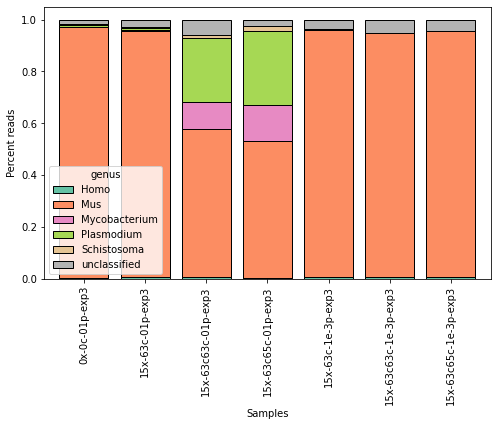

In [173]:
agg=df.loc[ (df["kraken_conf"] == 0.0) & (df['sample'].str.contains("exp3"))].groupby(['sample','genus']).agg({'taxon_num_frags': 'sum'}).reset_index()

piv=agg.pivot(index="sample", columns="genus", values="taxon_num_frags").fillna(0)

#convert to percentages
piv = piv.div(taxon_num_frags.filter(regex="-exp3"), axis=0)


corder = ["0x-0c-01p-exp3", 
          "15x-63c-01p-exp3", 
          "15x-63c63c-01p-exp3", 
          "15x-63c65c-01p-exp3", 
          "15x-63c-1e-3p-exp3", 
          "15x-63c63c-1e-3p-exp3", 
          "15x-63c65c-1e-3p-exp3" ]

piv = piv.reindex(corder, axis=0)

fig=piv.plot(kind='bar', 
             stacked=True, 
             figsize=(8,5), 
             ylabel="Percent reads", 
             xlabel="Samples", 
             width=0.8, 
             ec="black", 
             cmap="Set2")
fig.figure.savefig('exp3_prop.svg')
fig.figure.savefig('exp3_prop.png')

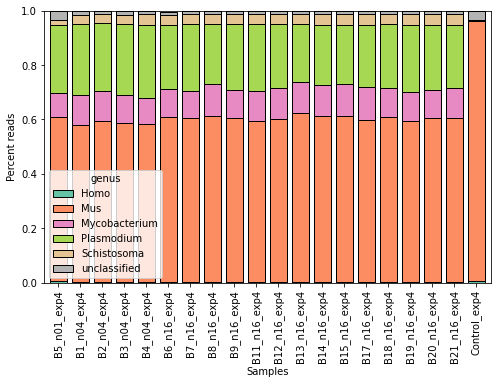

In [174]:
agg=df.loc[ (df["kraken_conf"] == 0.0) & (df['sample'].str.contains("exp4"))].groupby(['sample','genus']).agg({'taxon_num_frags': 'sum'}).reset_index()

piv=agg.pivot(index="sample", columns="genus", values="taxon_num_frags").fillna(0)

#convert to percentages
piv = piv.div(taxon_num_frags.filter(regex="exp4"), axis=0)


corder = ["B5_n01_exp4",
          "B1_n04_exp4",
          "B2_n04_exp4",
          "B3_n04_exp4",
          "B4_n04_exp4",
          "B6_n16_exp4",
          "B7_n16_exp4",
          "B8_n16_exp4",
          "B9_n16_exp4",
          "B11_n16_exp4",
          "B12_n16_exp4",
          "B13_n16_exp4",
          "B14_n16_exp4",
          "B15_n16_exp4",
          "B17_n16_exp4",
          "B18_n16_exp4",
          "B19_n16_exp4",
          "B20_n16_exp4",
          "B21_n16_exp4",
          "Control_exp4"]

piv = piv.reindex(corder, axis=0)

fig=piv.plot(kind='bar', 
             stacked=True, 
             figsize=(8,5), 
             ylabel="Percent reads", 
             xlabel="Samples", 
             width=0.8, 
             ec="black", 
             cmap="Set2",
             ylim=[0,1])
fig.figure.savefig('exp4_prop.svg')
fig.figure.savefig('exp4_prop.png')


## Increase or decrease in Kraken2 classification with varying conf

In [250]:
x=df.loc[ (df['sample'].str.contains("exp4"))].groupby(["sample", "species", "kraken_conf"]).agg({'taxon_num_frags': 'sum'}).reset_index()

perc_frags = []
tnf_dict = taxon_num_frags.to_dict()
for index, row in x.iterrows():
    perc_frag = row["taxon_num_frags"]/tnf_dict[row["sample"]]
    perc_frags.append(perc_frag)

x["perc_frags"] = perc_frags

piv=x.pivot(index=["sample", "species"], columns="kraken_conf", values="perc_frags").fillna(0).reset_index()
piv

piv_unc = piv.loc[piv["species"] == "unclassified"]
piv_c   = piv.loc[piv["species"] != "unclassified"]


In [256]:
piv_unc_perc

kraken_conf,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
7,0.018064,0.029183,0.045981,0.070557,0.105775,0.155813,0.252122,0.371236,0.533477,0.794578,1.0
15,0.018242,0.029894,0.047306,0.072530,0.108292,0.157478,0.248596,0.363667,0.523070,0.787250,1.0
23,0.015974,0.026342,0.042139,0.065278,0.099127,0.147520,0.241665,0.359158,0.522171,0.786927,1.0
31,0.014735,0.023581,0.037241,0.057935,0.089289,0.135076,0.230999,0.350726,0.517358,0.787188,1.0
39,0.014696,0.023715,0.037606,0.058447,0.089998,0.136308,0.230816,0.350646,0.517123,0.785853,1.0
47,0.015011,0.024427,0.038700,0.060272,0.092176,0.138456,0.231207,0.349101,0.514549,0.784004,1.0
55,0.016136,0.025852,0.040684,0.062403,0.095058,0.141919,0.236163,0.354184,0.518335,0.788131,1.0
63,0.016316,0.026474,0.041932,0.064796,0.098243,0.146311,0.240512,0.357725,0.522034,0.790355,1.0
71,0.017075,0.027960,0.044312,0.068390,0.102798,0.152236,0.247002,0.365423,0.527853,0.791566,1.0
79,0.021472,0.034261,0.052978,0.079437,0.117020,0.168594,0.266284,0.382889,0.542348,0.800611,1.0


In [251]:
piv_c_perc   = piv_c[[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].div(piv_c[0.0], axis=0)
piv_unc_perc = piv_unc[[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].div(piv_unc[1.0], axis=0)

piv_perc = pd.concat([piv_unc_perc, piv_c_perc]).sort_index()

In [257]:
pd.concat([piv_unc_perc, piv_c_perc]).sort_index()

kraken_conf,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1.000000,0.372351,0.191875,0.099763,0.046439,0.019891,0.009334,0.002907,0.001607,0.000765,0.000459
1,1.000000,0.989824,0.973185,0.949511,0.917061,0.872871,0.791366,0.699993,0.586832,0.433554,0.287487
2,1.000000,0.999719,0.999165,0.998125,0.995881,0.990919,0.978263,0.952002,0.882574,0.682521,0.490462
3,1.000000,0.998814,0.993848,0.985788,0.971412,0.947673,0.900809,0.844150,0.757595,0.569610,0.391405
4,1.000000,0.997767,0.994143,0.987803,0.975651,0.951477,0.899135,0.810267,0.680362,0.484988,0.317854
...,...,...,...,...,...,...,...,...,...,...,...
163,1.000000,0.995943,0.994722,0.992528,0.984166,0.941385,0.928428,0.898603,0.801407,0.641850,0.378826
164,1.000000,0.620816,0.612431,0.563884,0.555425,0.541155,0.444502,0.405958,0.321809,0.234645,0.183818
165,1.000000,0.109675,0.098558,0.095853,0.090845,0.057091,0.009415,0.005008,0.002304,0.000901,0.000000
166,1.000000,0.060146,0.057573,0.042780,0.041980,0.040989,0.038434,0.014428,0.012724,0.000348,0.000052


In [259]:
perc_df = pd.concat([piv[["sample", "species"]], piv_perc], axis=1)

In [280]:
perc_df

kraken_conf,sample,species,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,B10_n16_exp4,Homo sapiens,1.000000,0.372351,0.191875,0.099763,0.046439,0.019891,0.009334,0.002907,0.001607,0.000765,0.000459
1,B10_n16_exp4,Mus musculus,1.000000,0.989824,0.973185,0.949511,0.917061,0.872871,0.791366,0.699993,0.586832,0.433554,0.287487
2,B10_n16_exp4,Mycobacterium tuberculosis,1.000000,0.999719,0.999165,0.998125,0.995881,0.990919,0.978263,0.952002,0.882574,0.682521,0.490462
3,B10_n16_exp4,Plasmodium falciparum,1.000000,0.998814,0.993848,0.985788,0.971412,0.947673,0.900809,0.844150,0.757595,0.569610,0.391405
4,B10_n16_exp4,Plasmodium vivax,1.000000,0.997767,0.994143,0.987803,0.975651,0.951477,0.899135,0.810267,0.680362,0.484988,0.317854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Control_exp4,Plasmodium falciparum,1.000000,0.995943,0.994722,0.992528,0.984166,0.941385,0.928428,0.898603,0.801407,0.641850,0.378826
164,Control_exp4,Plasmodium vivax,1.000000,0.620816,0.612431,0.563884,0.555425,0.541155,0.444502,0.405958,0.321809,0.234645,0.183818
165,Control_exp4,Schistosoma bovis,1.000000,0.109675,0.098558,0.095853,0.090845,0.057091,0.009415,0.005008,0.002304,0.000901,0.000000
166,Control_exp4,Schistosoma mansoni,1.000000,0.060146,0.057573,0.042780,0.041980,0.040989,0.038434,0.014428,0.012724,0.000348,0.000052


In [293]:
perc_df["species"].unique()

array(['Homo sapiens', 'Mus musculus', 'Mycobacterium tuberculosis',
       'Plasmodium falciparum', 'Plasmodium vivax', 'Schistosoma bovis',
       'Schistosoma mansoni', 'unclassified'], dtype=object)

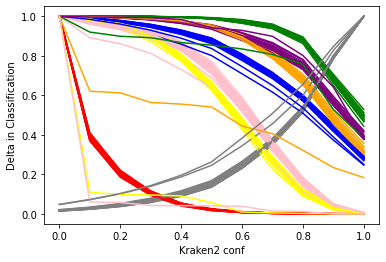

In [305]:
plot_cols = {
'Homo sapiens': "red",
'Mus musculus': "blue",
'Mycobacterium tuberculosis': "green",
'Plasmodium falciparum': "purple",
'Plasmodium vivax': "orange",
'Schistosoma bovis': "yellow",
'Schistosoma mansoni': "pink",
'unclassified': "grey"}

for index, row, in perc_df.iterrows():
    xs=list(row.drop(labels=["sample", "species"]).index)
    ys=list(row.drop(labels=["sample", "species"]).values)

    plt.plot(xs, ys, c=plot_cols[row["species"]], label=row["species"])

#plt.legend()    
plt.xlabel("Kraken2 conf")
plt.ylabel("Delta in Classification")

plt.savefig('delta_class.svg')
plt.savefig('delta_class.png', dpi=300)

plt.show()
    

## Get coverage at target loci

# Next

In [20]:
df.loc[(df["sample"]=="TK25651") & (df["genus"]=="Plasmodium")]


,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,lineage,superkingdom,kingdom,phylum,class,order,family,genus,species
103335,21.95,1028637,126,G,5820,Plasmodium,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,NaN
103336,18.93,887345,542315,G1,418107,Plasmodium (Laverania),TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,NaN
103337,2.89,135526,0,S,5833,Plasmodium falciparum,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
103338,2.89,135526,135526,S1,36329,Plasmodium falciparum 3D7,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
103339,2.12,99408,99408,S,5854,Plasmodium reichenowi,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium reichenowi
103340,0.96,44771,44771,S,880534,Plasmodium sp. gorilla clade G1,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G1
103341,0.92,42988,42988,S,880536,Plasmodium sp. gorilla clade G3,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G3
103342,0.48,22310,22310,S,880535,Plasmodium sp. gorilla clade G2,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G2
103343,0.00,21,21,S,720590,Plasmodium sp. DRC-Itaito,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. DRC-Itaito
103344,0.00,6,6,S,647221,Plasmodium gaboni,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium gaboni


In [130]:
sample = "TK25651_Exp5_42_P5"

r1_file="results/filter_reads/{}_filtered_R1_PE.fastq.gz".format(sample)
r2_file="results/filter_reads/{}_filtered_R2_PE.fastq.gz".format(sample)
results_tbl="results/kraken2/{}_kraken_results.tbl".format(sample)

#mammalia
target_taxa="Plasmodium"



In [122]:
#count number of lines for analyses
with open(results_tbl, 'r') as f:
    n_lines=len(f.readlines())
    
#
with open(results_tbl, 'r') as in_f:
    with open("outfile.txt", 'w') as out_f:
        for entry in tqdm(in_f, total=n_lines):
            if "Plasmodium" in entry:
                out_f.write("{}\n".format(entry.split("\t")[1]))

#extract with seqtk
! seqtk subseq results/filter_reads/TK25651_Exp5_42_P5_filtered_R1_PE.fastq.gz outfile.txt >test.fq


  0%|          | 0/4687054 [00:00<?, ?it/s]

In [142]:
with gzip.open(r1_file, "rt") as f:
    n_fq_seqs=len(f.readlines())/4
    
n_fq_seqs

4687054.0

In [157]:
target_reads=[]
r1_read_ids=read_ids
records=[]
with gzip.open(r1_file, "rt") as f:
    for record in tqdm(SeqIO.parse(f, "fastq"), total=n_fq_seqs):
        records.append(record)
        
        
        
#         if record.id in r1_read_ids:
#             target_reads.append(record)
#             r1_read_ids.remove(record.id)

  0%|          | 0/4687054.0 [00:00<?, ?it/s]

In [156]:
len(read_ids)

1026984

In [87]:
ncbi.get_taxid_translator([2])

{2: 'Bacteria'}

In [86]:
taxid

0

In [ ]:
#number of probes per group
grep ">" sl_decon_probes.fas | cut -f2 -d"_" | sort | uniq -c | sort -nr

In [ ]:
#num loci per group
grep ">" sl_decon_probes.fas | cut -f2,3 -d_ | sort | uniq | cut -f1 -d"_" | uniq -c | sort -nr

In [330]:
p_df = pd.read_csv("scratch/probe_locs.csv", sep=",")

orients    = [] 
seq_headers = []

for index, row in p_df.iterrows():
    orient="+"
    if row["stop"] > row["start"]:
        orient="-"
        
    orients.append(orient)

    seq_header=">{} |species=\"{}\",accession={},chrom={},start={},stop={},orient={}".format( row["probe_name"],
                                                                                              row["species"], 
                                                                                              row["ncbi_accession"], 
                                                                                              row["chrom"], 
                                                                                              row["start"], 
                                                                                              row["stop"], 
                                                                                              orient)             
    seq_headers.append(seq_header)
    
p_df["orient"] = orients
p_df["header"] = seq_headers

p_df


,species,ncbi_accession,probe_name,chrom,start,stop,orient,header
0,Anaplasma marginale,GCF_000011945,uce_anaplasma_207_p1,CP000030.1,686944.0,686865.0,+,">uce_anaplasma_207_p1 |species=""Anaplasma marg..."
1,Anaplasma marginale,GCF_000011945,uce_anaplasma_207_p2,CP000030.1,686917.0,686838.0,+,">uce_anaplasma_207_p2 |species=""Anaplasma marg..."
2,Anaplasma marginale,GCF_000020305,uce_anaplasma_207_p3,CP001079.1,685812.0,685733.0,+,">uce_anaplasma_207_p3 |species=""Anaplasma marg..."
3,Anaplasma ovis,GCF_002214625,uce_anaplasma_207_p49,CP015994.2,658171.0,658092.0,+,">uce_anaplasma_207_p49 |species=""Anaplasma ovi..."
4,Anaplasma ovis,GCF_002214625,uce_anaplasma_207_p50,CP015994.2,658144.0,658065.0,+,">uce_anaplasma_207_p50 |species=""Anaplasma ovi..."
...,...,...,...,...,...,...,...,...
39911,Yersinia pekkanenii,GCF_001244635,uce_yersinia_242_p28,CWJL01000018.1,36517.0,36596.0,-,">uce_yersinia_242_p28 |species=""Yersinia pekka..."
39912,Yersinia aldovae,GCF_000834395,uce_yersinia_241_p1,CP009781.1,2186277.0,2186356.0,-,">uce_yersinia_241_p1 |species=""Yersinia aldova..."
39913,Yersinia aldovae,GCF_000834395,uce_yersinia_241_p2,CP009781.1,2186304.0,2186383.0,-,">uce_yersinia_241_p2 |species=""Yersinia aldova..."
39914,Yersinia bercovieri,GCF_000167975,uce_yersinia_241_p5,AALC02000037.1,26712.0,26633.0,+,">uce_yersinia_241_p5 |species=""Yersinia bercov..."
